# Overview 

Last updated March 13, 2022.

This notebooks shows how to use Symphony with Seurat analyses. The workflow is as follows: 

1) Do standard Seurat analysis (with Harmony)

2) Create Symphony reference from Seurat object

3) Map query counts and metadata into Reference

4) Do downstream analysis with query Seurat object 

We demonstrate how Symphony can be used with alternative normalization methods: log(CP10k+1) and SCTransform.

In [1]:
#install.packages("remotes")
#remotes::install_github("satijalab/seurat-data") # data for tutorial

In [2]:
## Functions to link Seurat and Symphony
## These will eventually be pushed to packages 
source('utils_seurat.R')

In [3]:
suppressPackageStartupMessages({
    library(symphony)
    library(Seurat)
    suppressWarnings({library(SeuratData)})
    library(ggplot2)
    library(dplyr)
    library(magrittr)
    library(Matrix)
    library(sctransform)
})

## Load data for query and ref

In [4]:
## Install this example dataset
suppressWarnings({
    #SeuratData::InstallData('hcabm40k')
    SeuratData::LoadData('hcabm40k')    
})

An object of class Seurat 
17369 features across 40000 samples within 1 assay 
Active assay: RNA (17369 features, 0 variable features)

In [5]:
cells_ref <- hcabm40k@meta.data %>% subset(orig.ident %in% paste0('MantonBM', 1:4)) %>% rownames()
cells_query <- hcabm40k@meta.data %>% subset(orig.ident %in% paste0('MantonBM', 5:8)) %>% rownames()

In [6]:
hcabm40k@meta.data %>% head(3)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
MantonBM1_HiSeq_8-CCCAATCGTATGCTTG-1,MantonBM1,3235,856
MantonBM1_HiSeq_8-CTGCTGTAGGACACCA-1,MantonBM1,1566,653
MantonBM1_HiSeq_3-CAGCTGGGTACATGTC-1,MantonBM1,2103,716


# Use log(CP10k+1) for normalization

## Build reference

### Do Seurat analyses

In [7]:
.verbose <- FALSE
# Run standard Seurat pipeline with log normalization
obj <- Seurat::CreateSeuratObject(hcabm40k@assays$RNA@counts[, cells_ref]) %>% 
    NormalizeData(normalization.method = "LogNormalize", scale.factor = 10000) %>% 
    FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>% 
    ScaleData(verbose = .verbose) %>% 
    RunPCA(verbose = .verbose) %>% 
    RunHarmony.Seurat('orig.ident', verbose = .verbose) %>% 
    FindNeighbors(dims = 1:20, reduction = 'harmony', verbose = .verbose) %>%  # previous version of this tutorial was missing reduction argument
    FindClusters(resolution = 0.5, verbose = .verbose)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [8]:
## Currently, Seurat does not let you cache the umap model for future mapping
## Therefore, please use this custom function to learn a saveable UMAP model
obj[['umap']] <- RunUMAP2(Embeddings(obj, 'harmony')[, 1:20], 
                          assay='RNA', verbose=FALSE, umap.method='uwot', return.model=TRUE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


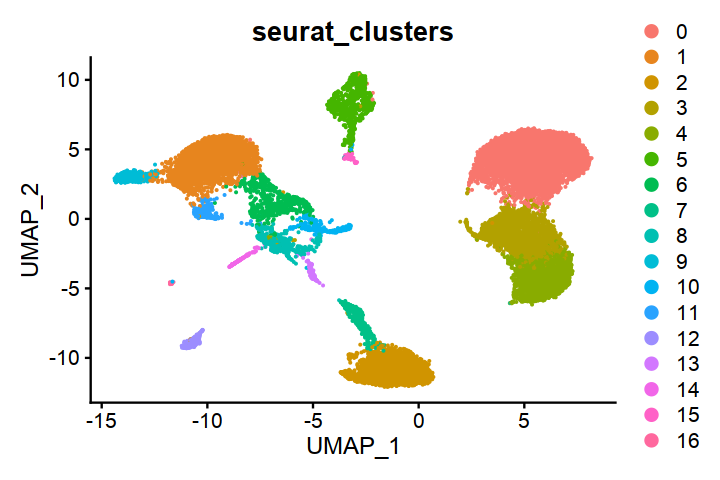

In [9]:
# Plot reference
options(repr.plot.height = 4, repr.plot.width = 6)
DimPlot(obj, reduction = 'umap', group.by = 'seurat_clusters', shuffle = TRUE)

### Make Symphony ref object 

Build Symphony reference from a Seurat object

In [10]:
ref <- buildReferenceFromSeurat(obj, verbose = TRUE, save_umap = TRUE, save_uwot_path = 'cache_symphony.uwot')

Saved embeddings

Saved soft cluster assignments

Saved variable gene information for 2000 genes.

Saved PCA loadings.

Saved metadata.

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

Finished nicely.



In [11]:
# Optionally, you can specify which normalization method was
# used to build the reference as a slot inside the Symphony object to 
# help record this information for future query users
ref$normalization_method = 'log(CP10k+1)'

## Map Query 

Map query starting from query counts and metadata

In [12]:
query <- mapQuery(
    hcabm40k@assays$RNA@counts[, cells_query], 
    hcabm40k@meta.data[cells_query, ], 
    ref,
    vars = 'orig.ident', 
    return_type = 'Seurat'
)

Normalizing

Scaling and synchronizing query gene expression

Found 2000 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.SymphonyQuery.harmony; see ?make.names for more details on syntax validity”


### UMAP

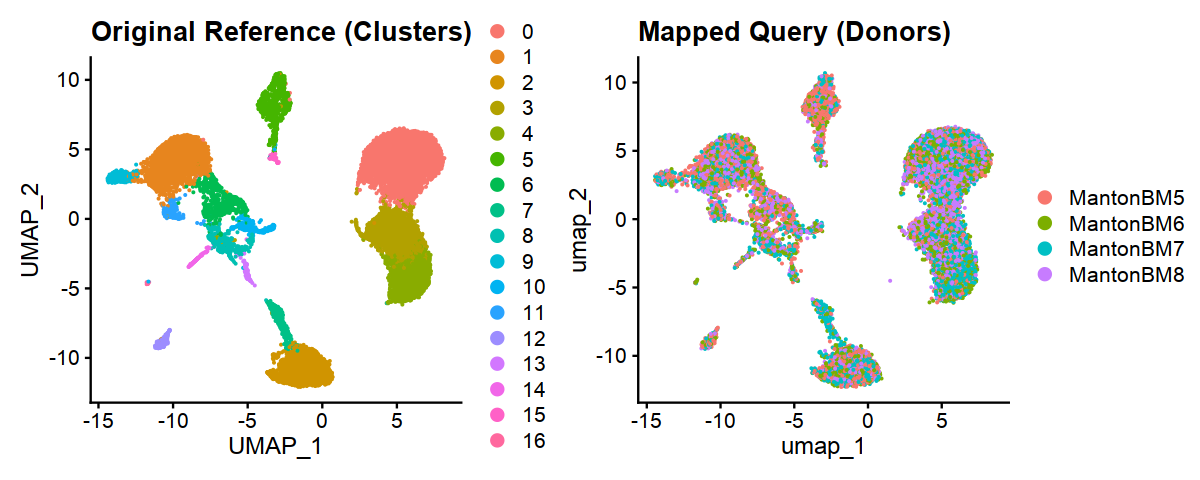

In [13]:
options(repr.plot.height = 4, repr.plot.width = 10)
(DimPlot(obj, reduction = 'umap', shuffle = TRUE) + labs(title = 'Original Reference (Clusters)')) + 
(DimPlot(query, reduction = 'umap', shuffle = TRUE) + labs(title = 'Mapped Query (Donors)'))

### Predict clusters 

In [14]:
query <- knnPredict.Seurat(query, ref, 'seurat_clusters')

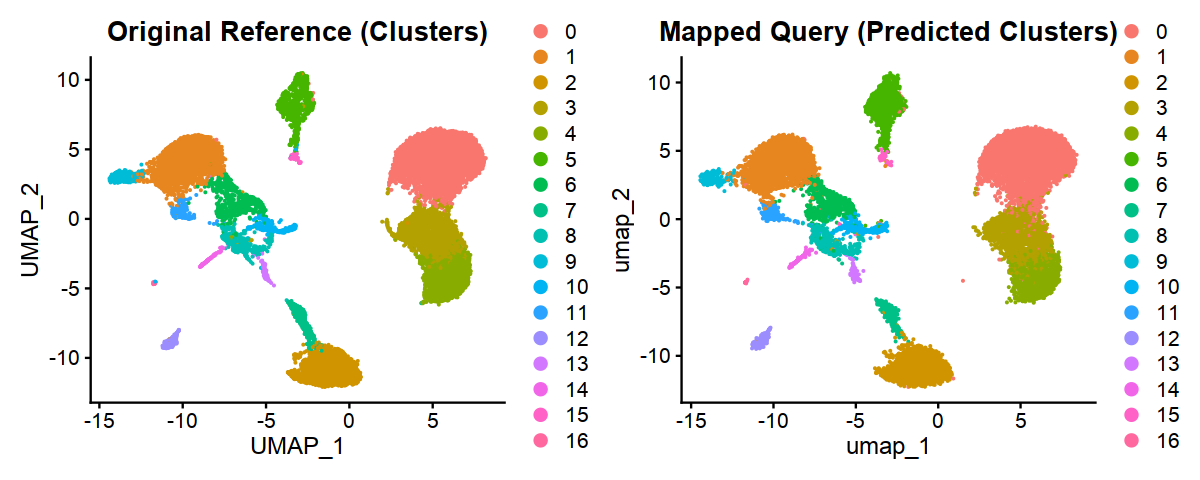

In [15]:
options(repr.plot.height = 4, repr.plot.width = 10)
(DimPlot(obj, reduction = 'umap', shuffle = TRUE, group.by = 'seurat_clusters') + labs(title = 'Original Reference (Clusters)')) + 
(DimPlot(query, reduction = 'umap', shuffle = TRUE, group.by = 'seurat_clusters') + labs(title = 'Mapped Query (Predicted Clusters)'))

# Use SCTransform for normalization

In this section, we will perform the same analysis, except we will use SCTransform for normalization instead of log(CP10k+1). 

**NOTE:** This normalization approach is different from how Symphony does normalization and scaling in the default code. By default, we would recommend the Symphony workflow with log(CP10k+1) normalization, but here we show how SCTransform can be used as an alternative normalization approach.

In [16]:
cells_ref <- hcabm40k@meta.data %>% subset(orig.ident %in% paste0('MantonBM', 1:4)) %>% rownames()
cells_query <- hcabm40k@meta.data %>% subset(orig.ident %in% paste0('MantonBM', 5:8)) %>% rownames()

## Build reference

### Do Seurat analyses

Using SCTransform tutorial: https://satijalab.org/seurat/articles/sctransform_vignette.html

In [17]:
.verbose <- TRUE

suppressWarnings({ # to suppress the SCTransform warning: "iteration limit reached"
    obj <- Seurat::CreateSeuratObject(hcabm40k@assays$RNA@counts[, cells_ref]) %>% 
        SCTransform(assay = 'RNA', verbose = .verbose) # use SCT
})

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17304 by 20000

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 160 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17304 genes



  |======================================================================| 100%


Computing corrected count matrix for 17304 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.931126 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



**Potentially helpful information regarding SCTransform:**

* "SCTransform returns a Seurat object with a new assay (named SCT by default) with counts being (corrected) counts, data being log1p(counts), scale.data being pearson residuals; sctransform::vst intermediate results are saved in misc slot of the new assay." (from https://rdrr.io/github/satijalab/seurat/man/SCTransform.html)
* "For most downstream analysis (dimensional reduction) you will use the residuals in scale.data just as you would with the RNA assay. Residuals for your most variable features are computed by default in SCTransform." (from https://github.com/satijalab/seurat/issues/3841)
* By default, SCTransform calculates 3,000 variable features

In [18]:
.verbose <- FALSE 
obj = obj %>%
        ScaleData(verbose = .verbose) %>% 
        RunPCA(verbose = .verbose) %>%
        RunHarmony.Seurat('orig.ident', assay.use = "SCT", 
                          project.dim = FALSE, verbose = .verbose) %>% 
        FindNeighbors(dims = 1:30, reduction = 'harmony', verbose = .verbose) %>% 
        FindClusters(resolution = 0.5, verbose = .verbose) # previous version of this tutorial was missing reduction argument

In [19]:
## Currently, Seurat does not let you cache the umap model for future mapping
## Therefore, please use this custom function to learn a saveable UMAP model
obj[['umap']] <- RunUMAP2(Embeddings(obj, 'harmony')[, 1:30], 
                          assay='RNA', verbose=FALSE, umap.method='uwot', return.model=TRUE)

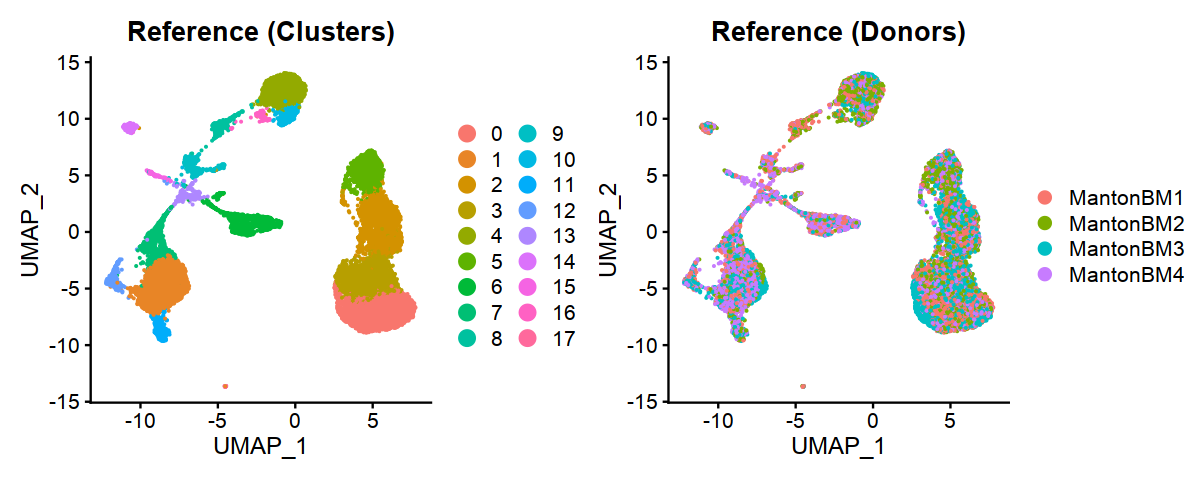

In [20]:
options(repr.plot.height = 4, repr.plot.width = 10)
(DimPlot(obj, reduction = 'umap', group.by = 'seurat_clusters', , shuffle = TRUE) + 
    guides(col=guide_legend(ncol = 2, override.aes = list(size=4))) +
    labs(title = 'Reference (Clusters)')) + 
(DimPlot(obj, reduction = 'umap', group.by = 'orig.ident', shuffle = TRUE) +
    labs(title = 'Reference (Donors)'))

### Make Symphony ref object 

In [21]:
ref <- buildReferenceFromSeurat(obj, assay = 'SCT', 
                        verbose=TRUE, save_umap=TRUE, save_uwot_path='cache_symphony_sct.uwot')

# Optionally, save reference normalization method for future query users
ref$normalization_method = 'SCTransform'

Saved embeddings

Saved soft cluster assignments

Saved variable gene information for 3000 genes.

Saved PCA loadings.

Saved metadata.

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

Finished nicely.



## Map Query 

Since the reference was normalized using SCTransform, the query should also be normalized using SCTransform prior to mapping. Because we will subset by the reference-calculated variable genes, we set `return.only.var.genes = FALSE` for the query to calculate the SCTransform residuals for all the genes (rather than query var genes).

In [22]:
## SCTransform the query
suppressWarnings({
    query_obj <- Seurat::CreateSeuratObject(hcabm40k@assays$RNA@counts[, cells_query]) %>% 
        SCTransform(assay = 'RNA', verbose = .verbose, return.only.var.genes = FALSE)
})

Instead of using the original query expression (`RNA@counts`) as input, we will use the Pearson residuals from SCTransform (`SCT@scale.data`). We also set `do_normalize = FALSE` to avoid re-normalizing the query.

In [23]:
query <- mapQuery(
    query_obj$SCT@scale.data, 
    hcabm40k@meta.data[cells_query, ], 
    ref,
    vars = 'orig.ident', 
    do_normalize = FALSE,
    return_type = 'Seurat' # return a Seurat object
)

Warning message:
“The following arguments are not used: row.names”
Scaling and synchronizing query gene expression

Found 2988 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.SymphonyQuery.harmony; see ?make.names for more details on syntax validity”


### UMAP

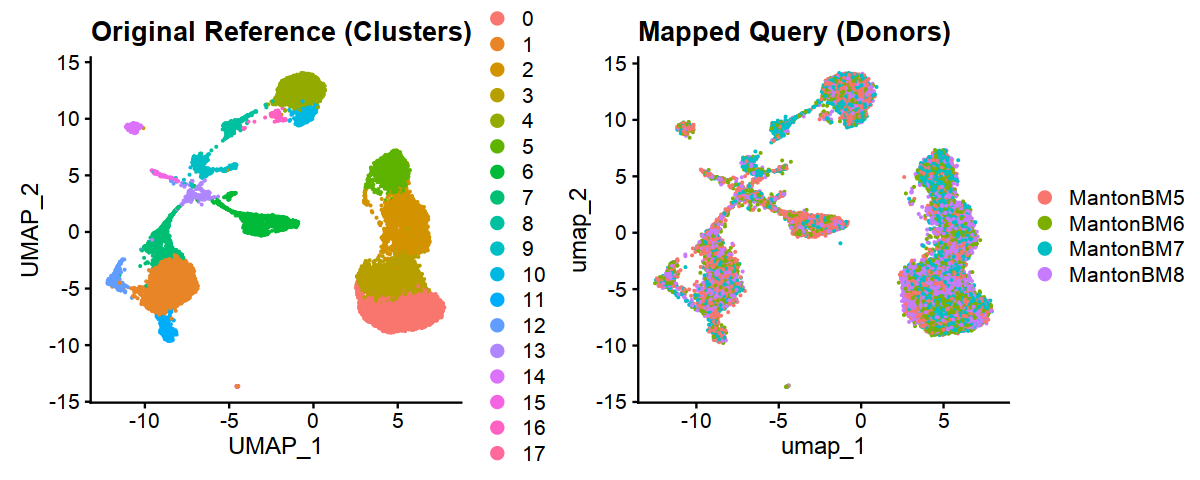

In [24]:
options(repr.plot.height = 4, repr.plot.width = 10)
(DimPlot(obj, reduction = 'umap', shuffle = TRUE) + labs(title = 'Original Reference (Clusters)')) + 
(DimPlot(query, reduction = 'umap', shuffle = TRUE) + labs(title = 'Mapped Query (Donors)'))

### Predict clusters 

In [25]:
query <- knnPredict.Seurat(query, ref, 'seurat_clusters')

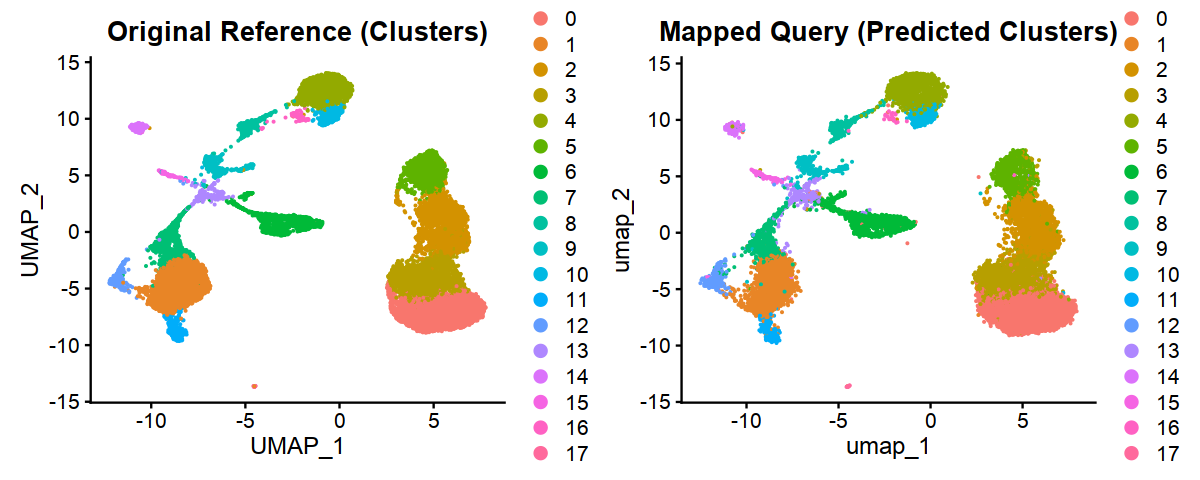

In [26]:
options(repr.plot.height = 4, repr.plot.width = 10)
(DimPlot(obj, reduction = 'umap', group.by = 'seurat_clusters', shuffle = TRUE) + labs(title = 'Original Reference (Clusters)')) + 
(DimPlot(query, reduction = 'umap', group.by = 'seurat_clusters', shuffle = TRUE) + labs(title = 'Mapped Query (Predicted Clusters)'))

# All done!

In [27]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] sctransform_0.3.2         Matrix_1.3-3             
 [3] magrittr_2.0.1            dplyr_1.0.7              
 [5] ggplot2_3.3.5             hcabm40k.SeuratData_3.0.0
 [7] SeuratData_0.2.1          SeuratObject_4.0.1       
 [9] Seurat_4.0.2              symphon